# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
#!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu102


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import GenericMask
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams["figure.figsize"] = [30,10]
plt.rcParams["figure.autolayout"] = True

# Define Necessary Functions

In [3]:
def calc_object_depth(obj_masks, depth_map):
    obj_num = obj_masks.shape[0]
    obj_depths = np.empty(obj_num)
    for i in range(obj_num):
        obj_depth_map = depth_map.copy()
        np.putmask(obj_depth_map, ~obj_masks[i], 0)
        obj_depths[i] = np.true_divide(obj_depth_map.sum(),(obj_depth_map!=0).sum())
    return obj_depths

In [4]:
def create_labels(classes, depths, class_names):
    labels = None
    if classes is not None:
        if class_names is not None and len(class_names) > 0:
            labels = [class_names[i] for i in classes]
        else:
            labels = [str(i) for i in classes]
    if depths is not None:
        if labels is None:
            labels = [d for d in depths]
        else:
            labels = ["{} {}".format(l, d) for l, d in zip(labels, depths)]
    return labels

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

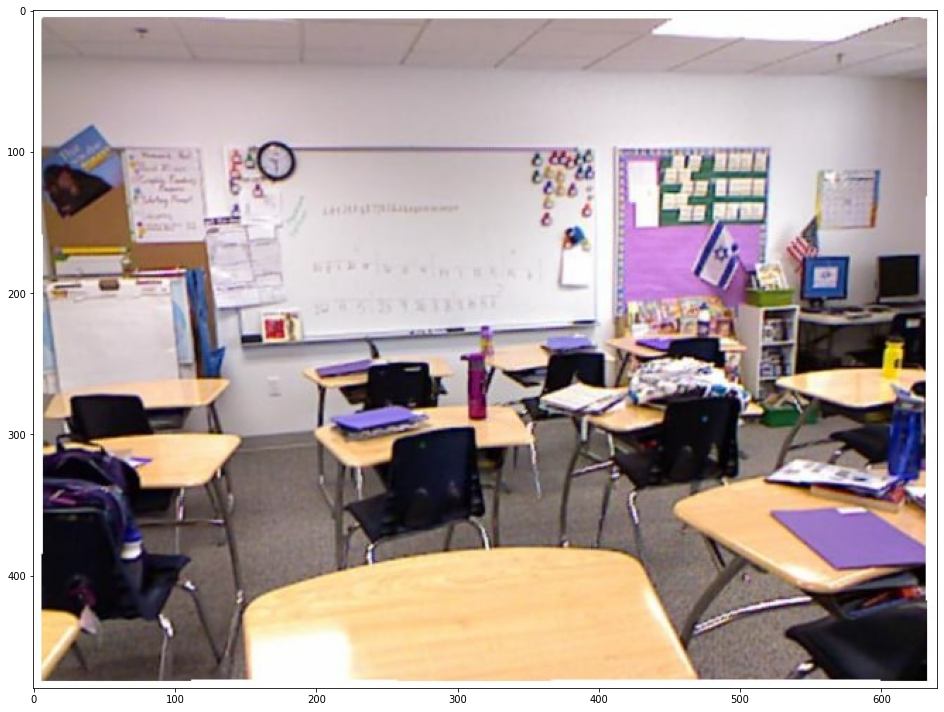

In [5]:
im = mpimg.imread("examples/267_image.jpg")
plt.imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [6]:
print(im.shape)

(480, 640, 3)


In [7]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/home/donken/anaconda3/envs/DL_Project/lib/python3.6/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/donken/anaconda3/envs/DL_Project/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
torch.cuda.empty_cache()

In [8]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([56, 56, 56, 60, 62, 60, 60, 39, 73, 60, 56, 56, 56, 73, 28, 60, 60, 73,
        60, 56, 56], device='cuda:0')
Boxes(tensor([[218.4409, 297.1686, 325.4824, 394.2884],
        [393.0473, 274.5023, 502.2317, 384.5771],
        [ 24.8237, 272.4890,  87.0559, 303.9976],
        [144.9606, 380.4879, 478.0254, 472.2747],
        [596.5289, 172.5592, 630.0823, 206.6884],
        [525.2728, 249.2321, 631.5765, 285.6161],
        [449.6442, 318.3533, 636.7704, 444.0862],
        [469.3374, 206.6481, 480.9751, 232.1867],
        [523.1632, 346.4011, 631.0769, 396.5385],
        [208.5340, 274.4334, 354.8962, 315.4069],
        [374.3260, 279.7187, 449.8751, 378.9202],
        [353.9789, 239.9368, 415.9125, 344.3923],
        [356.6109, 240.9410, 405.4339, 272.0737],
        [518.7374, 315.8319, 613.8470, 344.5461],
        [  7.9467, 352.6100,  73.5751, 429.6196],
        [198.1046, 266.8690, 363.2220, 388.2027],
        [ 14.8541, 256.3148, 138.7121, 293.1785],
        [212.2245, 279.153

In [9]:
outputs_instances = outputs["instances"].to("cpu")

In [10]:
depth_map = np.load("depth.npy")

In [11]:
obj_depths = calc_object_depth(outputs_instances.pred_masks, depth_map)
obj_depths_str = [('{:.2f}'.format(x) + ' m') for x in obj_depths] 

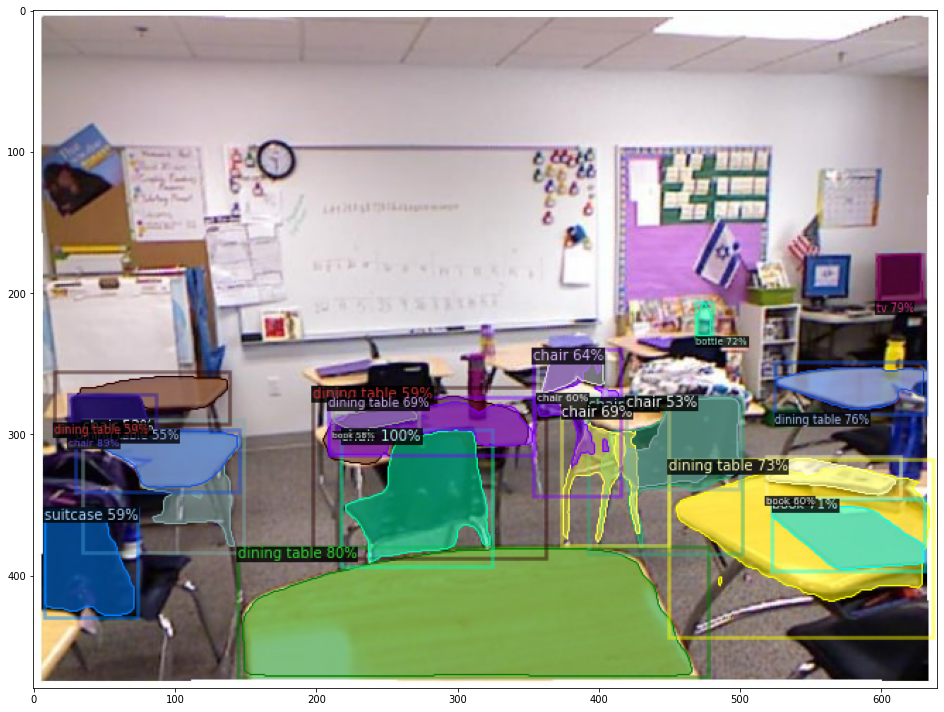

In [56]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_instance_predictions(outputs_instances)
plt.imshow(out.get_image()[:, :, ::-1])

#Visualize Masks
#b=np.asarray((outputs["instances"].pred_masks+0)[1].to("cpu"))
#print(b.shape)
#plt.imshow(b)

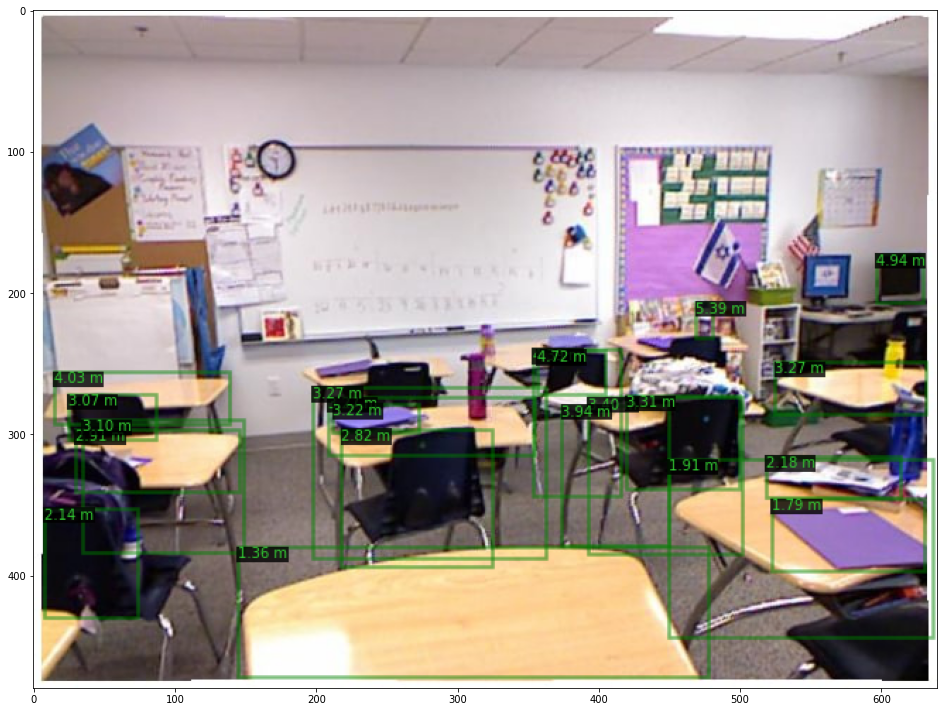

In [42]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
#out = v.draw_instance_predictions(outputs_instances)
#plt.imshow(out.get_image()[:, :, ::-1])

count = 0
for box in outputs_instances.pred_boxes:
    v.draw_box(box)
    v.draw_text(obj_depths_str[count], tuple(box[:2].numpy()), color='g', horizontal_alignment='left')
    count += 1
v = v.get_output()
img =  v.get_image()[:, :, ::-1]
plt.imshow(img)


/home/donken/anaconda3/envs/DL_Project/lib/python3.6/site-packages/detectron2/utils/visualizer.py:318: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  s, (width, height) = canvas.print_to_buffer()


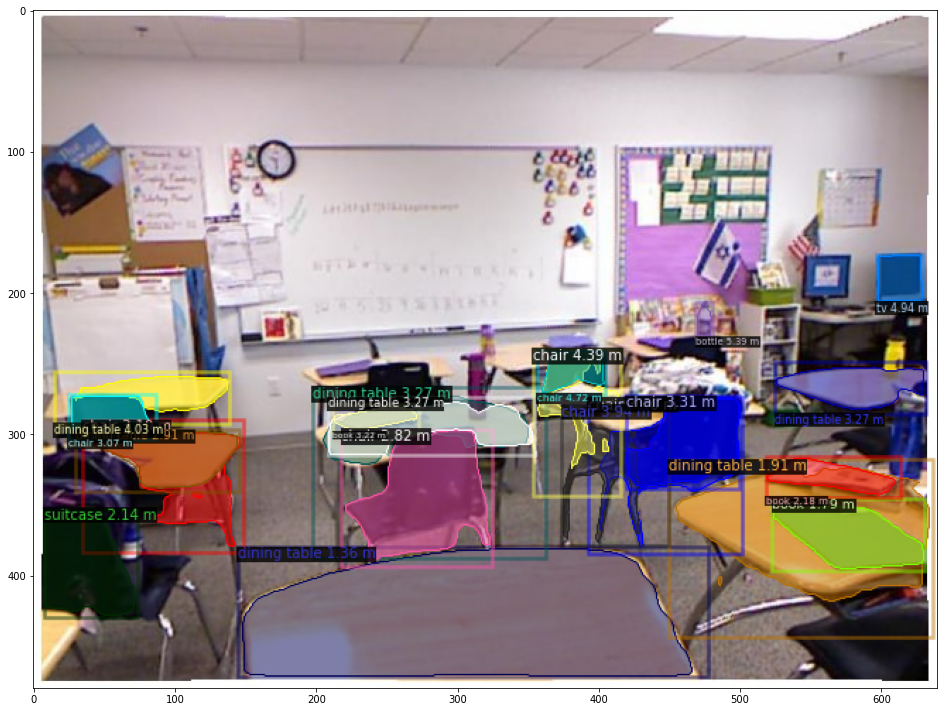

In [12]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
boxes = outputs_instances.pred_boxes if outputs_instances.has("pred_boxes") else None
scores = outputs_instances.scores if outputs_instances.has("scores") else None
classes = outputs_instances.pred_classes.tolist() if outputs_instances.has("pred_classes") else None
labels = create_labels(classes, obj_depths_str, v.metadata.get("thing_classes", None))
keypoints = outputs_instances.pred_keypoints if outputs_instances.has("pred_keypoints") else None

masks = np.asarray(outputs_instances.pred_masks)
masks = [GenericMask(x, v.output.height, v.output.width) for x in masks]

colors = None
alpha = 0.5

v.overlay_instances(
    masks=masks,
    boxes=boxes,
    labels=labels,
    keypoints=keypoints,
    assigned_colors=colors,
    alpha=alpha,
)
plt.imshow(v.output.get_image()[:, :, ::-1])